In [23]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
import random
import os
warnings.filterwarnings('ignore')

# TensorFlow/Keras untuk SimpleRNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn untuk evaluasi dan preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import display


# Set random seed untuk reproducibility
SEED = 42
set_random_seeds(SEED)



## 1. Data Loading dan Eksplorasi

In [24]:

# Dataset utama tweets
df_tweets = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')
print(f"Dataset Tweets: {df_tweets.shape}")
print(f"Kolom: {list(df_tweets.columns)}")
print()

# Dataset emoji mapping
df_emoji = pd.read_csv('master_emoji.csv')
print(f"Dataset Emoji: {df_emoji.shape}")
print(f"Kolom: {list(df_emoji.columns)}")
print()

# Stopwords list
df_stopwords = pd.read_csv('stopword_tweet_pilkada_DKI_2017.csv', header=None)
stopwords_list = df_stopwords[0].tolist()
print(f"Jumlah Stopwords: {len(stopwords_list)}")
print(f"Sample stopwords: {stopwords_list[:10]}")
print()

# print contoh data dal mbentuk tabel rapih
# print contoh data dalam bentuk tabel rapih
print("Contoh Data Tweets:")
# print(df_tweets.head())  # ← Ganti baris ini

# Opsi 1: Gunakan display() untuk formatting yang lebih baik
display(df_tweets.head())


Dataset Tweets: (900, 4)
Kolom: ['Id', 'Sentiment', 'Pasangan Calon', 'Text Tweet']

Dataset Emoji: (165, 5)
Kolom: ['ID', 'Emoji', 'Sentiment', 'Makna Emoji', 'Special Tag']

Jumlah Stopwords: 784
Sample stopwords: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'aja', 'akan', 'akankah']

Contoh Data Tweets:


,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


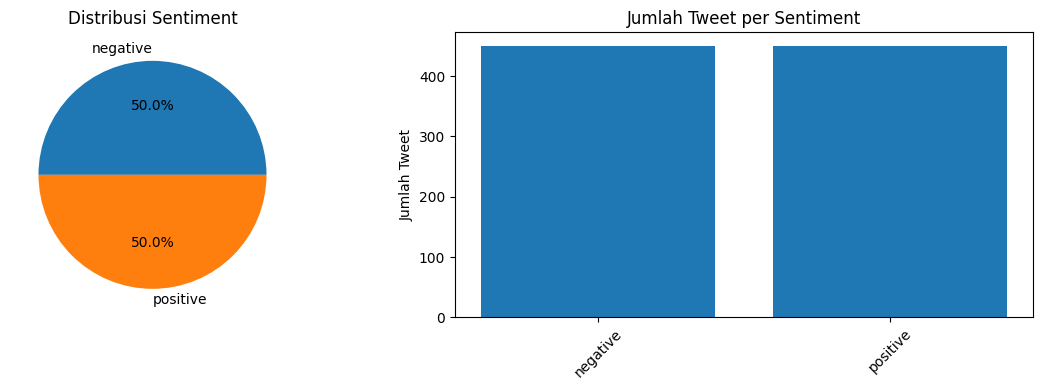

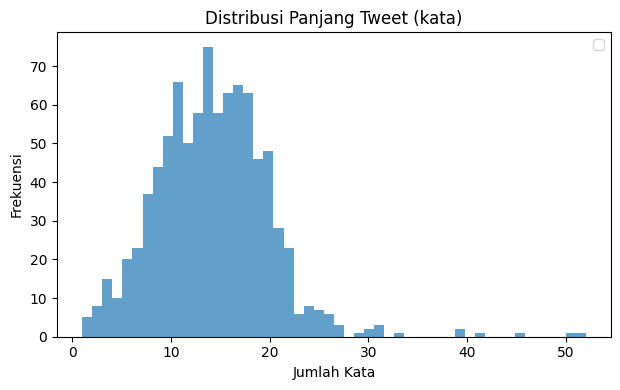

In [25]:
# Visualisasi distribusi data
plt.figure(figsize=(12, 4))

# Subplot 1: Pie chart untuk distribusi sentiment
plt.subplot(1, 2, 1)
sentiment_counts = df_tweets['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribusi Sentiment')

# Subplot 2: Bar chart untuk jumlah tweet per sentiment
plt.subplot(1, 2, 2)
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Jumlah Tweet per Sentiment')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analisis panjang tweet - menghitung panjang karakter dan jumlah kata
df_tweets['text_length'] = df_tweets['Text Tweet'].str.len()
df_tweets['word_count'] = df_tweets['Text Tweet'].str.split().str.len()

# Visualisasi distribusi panjang tweet dalam jumlah kata
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_tweets['word_count'], bins=50, alpha=0.7)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Tweet (kata)')
plt.legend()

plt.tight_layout()
plt.show()

## 2. Preprocessing 

In [26]:
# Membuat mapping emoji ke makna, special tag, dan sentiment
emoji_to_meaning = {}
emoji_to_special_tag = {}
emoji_to_sentiment = {}

# Iterasi melalui dataframe emoji untuk membuat dictionary mapping
for _, row in df_emoji.iterrows():
    emoji = row['Emoji']
    meaning = row['Makna Emoji'].lower() 
    special_tag = row['Special Tag']
    sentiment = row['Sentiment']

    emoji_to_meaning[emoji] = meaning
    emoji_to_special_tag[emoji] = special_tag
    emoji_to_sentiment[emoji] = sentiment


# Kata negasi yang harus dipertahankan (tidak dihapus sebagai stopword)
negation_words = {
    'tidak', 'bukan', 'jangan', 'gak', 'gag', 'ngga', 'nggak', 
    'tak', 'tanpa', 'belum', 'bukanlah', 'tidaklah', 'jangankan',
    'mustahil', 'tiada'
}

# Filter stopwords - hapus kata negasi dari daftar stopword
filtered_stopwords = set([word for word in stopwords_list if word not in negation_words])

def preprocess_text(text):
    """
    Comprehensive text preprocessing untuk sentiment analysis
    """
    if pd.isna(text):
        return ""
    
    # 1. Normalisasi huruf kecil
    text = str(text).lower()
    
    # 2. Hapus URL
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # 3. Hapus mention (@username)
    text = re.sub(r'@\w+', '', text)
    
    # 4. Hapus hashtag (#hashtag) tapi pertahankan teksnya
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 5. Hilangkan repetisi huruf berlebih (contoh: baaaagus -> bagus)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # 6. Ganti emoji dengan makna + special tag + sentiment token
    for emoji, meaning in emoji_to_meaning.items():
        if emoji in text:
            special_tag = emoji_to_special_tag[emoji]
            sentiment = emoji_to_sentiment[emoji]
            
            # Buat replacement: meaning + special_tag + sentiment_token
            sentiment_token = f"<EMO_{sentiment.upper()}>"
            replacement = f"{meaning} {special_tag} {sentiment_token}"
            
            text = text.replace(emoji, replacement)
    
    # 7. Hapus karakter non-alfanumerik kecuali spasi dan <> untuk token
    text = re.sub(r'[^a-zA-Z0-9\s<>_]', ' ', text)
    
    # 8. Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # 9. Tokenisasi dan hapus stopword (kecuali negasi)
    words = text.split()
    words = [word for word in words if word not in filtered_stopwords or word in negation_words]
    
    return ' '.join(words)


Dataset size: 900 -> 900 (removed 0 empty texts)

=== COMPARISON BEFORE vs AFTER PREPROCESSING ===

1. Sentiment: negative
   Original:  Banyak akun kloning seolah2 pendukung #agussilvy mulai menyerang paslon #aniessandi dengan opini dan argumen pmbenaran..jangan terkecoh
   Processed: akun kloning seolah2 pendukung agussilvy menyerang paslon aniessandi opini argumen pmbenaran jangan terkecoh

2. Sentiment: negative
   Original:  #agussilvy bicara apa kasihan yaa...lap itu air matanya wkwkwkwk
   Processed: agussilvy bicara kasihan yaa lap air matanya wkwkwkwk

3. Sentiment: negative
   Original:  Kalau aku sih gak nunggu hasil akhir QC tp lagi nunggu motif cuitan pak @SBYudhoyono kayak apa.. pasca #AgusSilvy Nyungsep..
   Processed: sih gak nunggu hasil qc tp nunggu motif cuitan kayak pasca agussilvy nyungsep

4. Sentiment: negative
   Original:  Kasian oh kasian dengan peluru 1milyar untuk tiap RW #agussilvy tidak mempan menangin pilkada #QuickCount #PilkadaSerentak2017
   Processed:

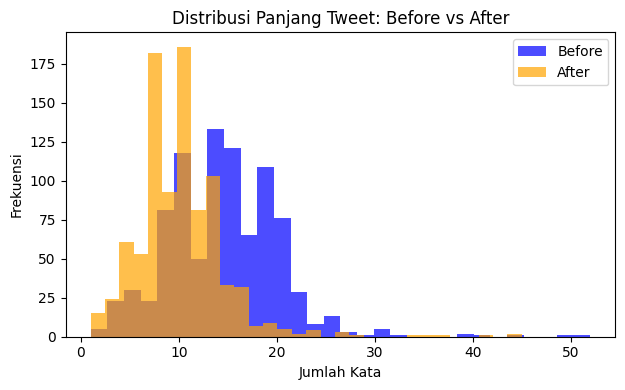

In [27]:

# Preprocessing text
df_tweets['processed_text'] = df_tweets['Text Tweet'].apply(preprocess_text)

# Remove empty texts after preprocessing
initial_count = len(df_tweets)
df_tweets = df_tweets[df_tweets['processed_text'].str.len() > 0]
final_count = len(df_tweets)

print(f"Dataset size: {initial_count} -> {final_count} (removed {initial_count - final_count} empty texts)")

# Update word count after preprocessing
df_tweets['processed_word_count'] = df_tweets['processed_text'].str.split().str.len()

# Tentukan max_len berdasarkan persentil 95
max_len = int(np.percentile(df_tweets['processed_word_count'], 95))


# Show comparison
print(f"\n=== COMPARISON BEFORE vs AFTER PREPROCESSING ===")
for i in range(5):
    original = df_tweets.iloc[i]['Text Tweet']
    processed = df_tweets.iloc[i]['processed_text']
    sentiment = df_tweets.iloc[i]['Sentiment']
    
    print(f"\n{i+1}. Sentiment: {sentiment}")
    print(f"   Original:  {original}")
    print(f"   Processed: {processed}")

# Visualisasi perubahan distribusi panjang
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_tweets['word_count'], bins=30, alpha=0.7, label='Before', color='blue')
plt.hist(df_tweets['processed_word_count'], bins=30, alpha=0.7, label='After', color='orange')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Tweet: Before vs After')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Feature Engineering: Tokenization & Vectorization

In [28]:
# Tokenization dan Vektorisasi
print("=== TOKENIZATION & VECTORIZATION ===")

# Persiapkan data
texts = df_tweets['processed_text'].tolist()
labels = df_tweets['Sentiment'].tolist()

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Label classes: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")
print(f"Label distribution: {np.bincount(encoded_labels)}")

# Setup Tokenizer
vocab_size = 10000  # Ukuran kosakata maksimal
oov_token = "<OOV>"  # Out-of-vocabulary token

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)

# Statistik tokenizer
word_index = tokenizer.word_index
actual_vocab_size = min(len(word_index), vocab_size)

print(f"\nVocabulary size: {actual_vocab_size}")
print(f"Total unique words: {len(word_index)}")

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Padding/Truncating ke max_len
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Sequences shape: {padded_sequences.shape}")
print(f"Max sequence length: {max_len}")

# Sample tokenization
print(f"\n=== SAMPLE TOKENIZATION ===")
for i in range(3):
    original_text = texts[i]
    sequence = sequences[i]
    padded = padded_sequences[i]
    
    print(f"\n{i+1}. Text: {original_text}")
    print(f"   Sequence: {sequence[:10]}...")  # First 10 tokens
    print(f"   Padded length: {len(padded)}")
    print(f"   Non-zero elements: {np.count_nonzero(padded)}")

# Vocabulary analysis
print(f"\n=== VOCABULARY ANALYSIS ===")
word_freq = tokenizer.word_counts
most_common_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 most frequent words:")
for word, freq in most_common_words:
    print(f"  {word}: {freq}")

# Check special tokens
special_tokens = [word for word in word_index.keys() if '<' in word and '>' in word]
print(f"\nSpecial tokens found: {len(special_tokens)}")
print(f"Sample special tokens: {special_tokens[:10]}")



=== TOKENIZATION & VECTORIZATION ===
Label classes: ['negative' 'positive']
Number of classes: 2
Label distribution: [450 450]

Vocabulary size: 3112
Total unique words: 3112
Sequences shape: (900, 17)
Max sequence length: 17

=== SAMPLE TOKENIZATION ===

1. Text: akun kloning seolah2 pendukung agussilvy menyerang paslon aniessandi opini argumen pmbenaran jangan terkecoh
   Sequence: [100, 1046, 1047, 29, 60, 579, 48, 6, 1048, 1049]...
   Padded length: 17
   Non-zero elements: 13

2. Text: agussilvy bicara kasihan yaa lap air matanya wkwkwkwk
   Sequence: [60, 392, 186, 187, 1052, 275, 580, 1053]...
   Padded length: 17
   Non-zero elements: 8

3. Text: sih gak nunggu hasil qc tp nunggu motif cuitan kayak pasca agussilvy nyungsep
   Sequence: [188, 67, 222, 54, 393, 1054, 222, 1055, 223, 189]...
   Padded length: 17
   Non-zero elements: 13

=== VOCABULARY ANALYSIS ===
Top 20 most frequent words:
  ahy: 294
  ahokdjarot: 210
  ahok: 179
  face: 154
  aniessandi: 152
  pilkadadki2017: 

## 4. Dataset Splitting (Stratified)

In [29]:
# Stratified split: 80% train, 10% validation, 10% test
print("=== DATASET SPLITTING ===")

X = padded_sequences
y = encoded_labels

# First split: 80% train, 20% temp (for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 10% validation, 10% test (from 20% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Total dataset: {len(X)}")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check stratification
def check_stratification(y_split, split_name):
    unique, counts = np.unique(y_split, return_counts=True)
    percentages = counts / len(y_split) * 100
    print(f"\n{split_name} distribution:")
    for class_idx, (count, pct) in enumerate(zip(counts, percentages)):
        class_name = label_encoder.classes_[class_idx]
        print(f"  {class_name}: {count} ({pct:.1f}%)")

check_stratification(y, "Original")
check_stratification(y_train, "Train")
check_stratification(y_val, "Validation")
check_stratification(y_test, "Test")


# Class weights untuk handling imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


=== DATASET SPLITTING ===
Total dataset: 900
Train: 720 (80.0%)
Validation: 90 (10.0%)
Test: 90 (10.0%)

Original distribution:
  negative: 450 (50.0%)
  positive: 450 (50.0%)

Train distribution:
  negative: 360 (50.0%)
  positive: 360 (50.0%)

Validation distribution:
  negative: 45 (50.0%)
  positive: 45 (50.0%)

Test distribution:
  negative: 45 (50.0%)
  positive: 45 (50.0%)


## 5. Model Architecture: SimpleRNN (Many-to-One)

### Arsitektur RNN yang Digunakan:
- **Input**: Padded sequences (batch_size, max_len)
- **Embedding**: Maps token indices to dense vectors 
- **SimpleRNN**: $h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)$ 
- **Output**: Final hidden state $h_T$ untuk klasifikasi
- **Dense**: Softmax untuk multi-class classification

### Rumus Parameter RNN:
$$\#\theta_{RNN} = (d + u + 1) \times u$$
$$\#\theta_{Dense} = u \times C + C$$

Dimana:
- $d$ = embedding_dim 
- $u$ = rnn_units
- $C$ = num_classes

**PENTING: Hanya menggunakan SimpleRNN, TIDAK MENGGUNAKAN LSTM/GRU/Transformer**

In [30]:
def create_simple_rnn_model(vocab_size, embedding_dim, rnn_units, max_len, num_classes, dropout_rate=0.2):
    """
    Membuat model SimpleRNN untuk sentiment classification (many-to-one)
    
    PENTING: Model ini HANYA menggunakan SimpleRNN, TIDAK menggunakan LSTM/GRU
    
    Args:
        vocab_size: Ukuran vocabulary
        embedding_dim: Dimensi embedding vector
        rnn_units: Jumlah hidden units di SimpleRNN
        max_len: Panjang maksimal sequence
        num_classes: Jumlah kelas output
        dropout_rate: Dropout rate untuk regularization
    """
    
    model = Sequential([
        # Embedding layer: mengubah token indices menjadi dense vectors
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            name='embedding'
        ),
        
        # SimpleRNN layer: PURE RNN implementation
        # return_sequences=False untuk many-to-one (hanya output terakhir)
        # Implementasi: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
        SimpleRNN(
            units=rnn_units,
            return_sequences=False,  # Many-to-one: hanya h_T yang digunakan
            dropout=dropout_rate,    # Dropout untuk input connections
            recurrent_dropout=dropout_rate,  # Dropout untuk recurrent connections
            name='simple_rnn'
        ),
        
        # Dense output layer dengan softmax untuk multi-class classification
        Dense(
            units=num_classes,
            activation='softmax',
            name='output'
        )
    ])
    
    return model

# Hyperparameters
embedding_dim = 100
rnn_units = 64  # Akan dicoba beberapa nilai: 32, 64, 128
dropout_rate = 0.2

print("=== MODEL ARCHITECTURE ===")
print(f"Vocabulary size: {actual_vocab_size}")
print(f"Embedding dimension: {embedding_dim}")
print(f"RNN units: {rnn_units}")
print(f"Max sequence length: {max_len}")
print(f"Number of classes: {num_classes}")
print(f"Dropout rate: {dropout_rate}")

# Create model with vocab_size + 1 for proper indexing
model = create_simple_rnn_model(
    vocab_size=actual_vocab_size + 1,  # +1 for proper indexing (0 to vocab_size)
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    max_len=max_len,
    num_classes=num_classes,
    dropout_rate=dropout_rate
)

# Build model dengan input shape untuk menghitung parameter
model.build(input_shape=(None, max_len))

# Model summary
print(f"\n=== MODEL SUMMARY ===")
model.summary()

# Hitung parameter manual berdasarkan rumus
print(f"\n=== MANUAL PARAMETER CALCULATION ===")
vocab_size_with_padding = actual_vocab_size + 1  # +1 for proper indexing
print(f"Embedding parameters: {vocab_size_with_padding} × {embedding_dim} = {vocab_size_with_padding * embedding_dim:,}")

# SimpleRNN parameters: (d + u + 1) × u
rnn_params = (embedding_dim + rnn_units + 1) * rnn_units
print(f"SimpleRNN parameters: ({embedding_dim} + {rnn_units} + 1) × {rnn_units} = {rnn_params:,}")

# Dense parameters: u × C + C  
dense_params = rnn_units * num_classes + num_classes
print(f"Dense parameters: {rnn_units} × {num_classes} + {num_classes} = {dense_params:,}")

total_params_manual = vocab_size_with_padding * embedding_dim + rnn_params + dense_params
print(f"Total parameters (manual): {total_params_manual:,}")

# Verify dengan model.count_params()
total_params_keras = model.count_params()
print(f"Total parameters (Keras): {total_params_keras:,}")
print(f"Match: {total_params_manual == total_params_keras}")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Karena labels berupa integers
    metrics=['accuracy']
)

print(f"\n=== MODEL COMPILED ===")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss: SparseCategoricalCrossentropy")
print(f"Metrics: Accuracy")
print(f"\nModel ready for training with BPTT (Backpropagation Through Time)!")

=== MODEL ARCHITECTURE ===
Vocabulary size: 3112
Embedding dimension: 100
RNN units: 64
Max sequence length: 17
Number of classes: 2
Dropout rate: 0.2

=== MODEL SUMMARY ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 100)        │       311,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,990 (1.23 MB)

 Trainable params: 321,990 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


=== MANUAL PARAMETER CALCULATION ===
Embedding parameters: 3113 × 100 = 311,300
SimpleRNN parameters: (100 + 64 + 1) × 64 = 10,560
Dense parameters: 64 × 2 + 2 = 130
Total parameters (manual): 321,990
Total parameters (Keras): 321,990
Match: True

=== MODEL COMPILED ===
Optimizer: Adam (lr=0.001)
Loss: SparseCategoricalCrossentropy
Metrics: Accuracy

Model ready for training with BPTT (Backpropagation Through Time)!


# 6. Training dengan BPTT (Backpropagation Through Time)

### Algoritma BPTT:
1. **Forward Pass**: RNN memproses sequence secara berurutan
   - $h_1 = \tanh(W_{xh}x_1 + b_h)$  
   - $h_2 = \tanh(W_{xh}x_2 + W_{hh}h_1 + b_h)$
   - ...
   - $h_T = \tanh(W_{xh}x_T + W_{hh}h_{T-1} + b_h)$

2. **Loss Calculation**: $L = -\sum_{k=1}^{C} y_k \log \hat{y}_k$

3. **Backward Pass**: Gradien mengalir mundur melalui waktu
   - $\frac{\partial L}{\partial h_T}, \frac{\partial L}{\partial h_{T-1}}, ..., \frac{\partial L}{\partial h_1}$

4. **Parameter Update**: Gradien diakumulasi untuk semua timesteps

In [31]:
# Training Setup
print("=== TRAINING SETUP ===")

# Callbacks dengan setting untuk reproducibility yang lebih baik
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,          # Increased patience untuk stabilitas
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001      # Minimum improvement required
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,          # Increased patience
        min_lr=1e-6,
        verbose=1,
        min_delta=0.001      # Minimum improvement required
    )
]

# Training parameters
batch_size = 32
epochs = 30

print(f"Batch size: {batch_size}")
print(f"Max epochs: {epochs}")
print(f"Class weights: {class_weight_dict}")
print()

# Start training with BPTT
print("=== STARTING TRAINING WITH BPTT ===")
print("Training SimpleRNN menggunakan Backpropagation Through Time...")
print("- Forward pass: RNN memproses sequence h_t = tanh(W_xh*x_t + W_hh*h_{t-1} + b_h)")
print("- Backward pass: Gradien mengalir mundur melalui semua timesteps")
print("- Parameter update: Gradien diakumulasi untuk W_xh, W_hh, dan bias")
print()

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Handle class imbalance
    callbacks=callbacks,
    verbose=1
)

print(f"\n=== TRAINING COMPLETED ===")
print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best val_loss: {min(history.history['val_loss']):.4f}")


=== TRAINING SETUP ===
Batch size: 32
Max epochs: 30
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}

=== STARTING TRAINING WITH BPTT ===
Training SimpleRNN menggunakan Backpropagation Through Time...
- Forward pass: RNN memproses sequence h_t = tanh(W_xh*x_t + W_hh*h_{t-1} + b_h)
- Backward pass: Gradien mengalir mundur melalui semua timesteps
- Parameter update: Gradien diakumulasi untuk W_xh, W_hh, dan bias

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5222 - loss: 0.7133 - val_accuracy: 0.4889 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5750 - loss: 0.6767 - val_accuracy: 0.5889 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6917 - loss: 0.5932 - val_accuracy: 0.6000 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7958 - loss: 0.4651 - val_accuracy: 0.5889

## 7. Evaluation & Analysis

=== MODEL EVALUATION ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train Accuracy: 0.9917
Validation Accuracy: 0.7222
Test Accuracy: 0.6667

=== CLASSIFICATION REPORT (TEST SET) ===
              precision    recall  f1-score   support

    negative       0.68      0.62      0.65        45
    positive       0.65      0.71      0.68        45

    accuracy                           0.67        90
   macro avg       0.67      0.67      0.67        90
weighted avg       0.67      0.67      0.67        90

=== CONFUSION MATRIX ===
[[28 17]
 [13 32]]


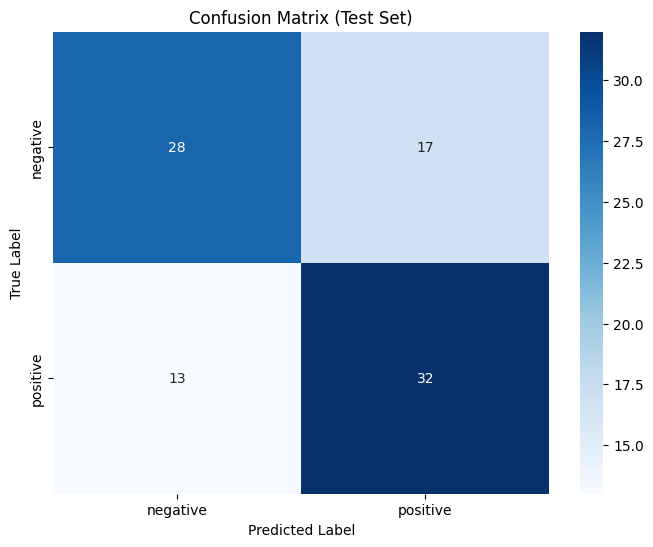

=== PER-CLASS METRICS ===
      Class  Precision    Recall  F1-Score  Support
0  negative   0.682927  0.622222  0.651163       45
1  positive   0.653061  0.711111  0.680851       45

Precision: 0.6680, Recall: 0.6667, F1: 0.6660


In [32]:
# Model Evaluation
print("=== MODEL EVALUATION ===")

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print()

# Detailed classification report
print("=== CLASSIFICATION REPORT (TEST SET) ===")
class_names = label_encoder.classes_
print(classification_report(y_test, y_test_pred_classes, target_names=class_names))

# Confusion Matrix
print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_test_pred_classes)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class metrics
print("=== PER-CLASS METRICS ===")
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred_classes, average=None, labels=range(num_classes)
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(metrics_df)

# Macro and weighted averages
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred_classes, average='macro'
)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred_classes, average='weighted'
)

print(f"\nPrecision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1: {macro_f1:.4f}")



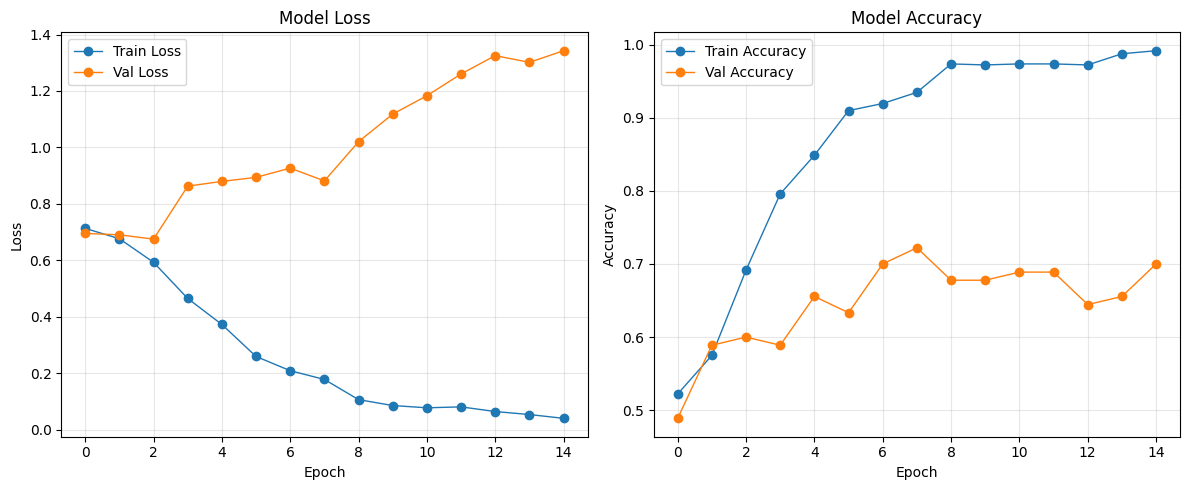

In [34]:
import matplotlib.pyplot as plt

hist = history.history
acc = hist.get('accuracy') or hist.get('acc')
val_acc = hist.get('val_accuracy') or hist.get('val_acc')
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(len(loss))

plt.figure(figsize=(12,5))

# subplot kiri: Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label='Train Loss', marker='o', linewidth=1)
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o', linewidth=1)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# subplot kanan: Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o', linewidth=1)
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o', linewidth=1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
